# 2022 Systematic Trading Education Ceritificate Skeleton Code Lecture 1


## Introduction
In this lecture we will be focussing on developing code for both a relative and time series momentum strategies. This lecture will also focus on introducing QT Capital's own skeleton code for backtesting strategies. Note that in order to access Financial price data we use the module yfinance, which has to be first installed using the Python command pip install done below. The yfinance module allows for the easy pulling of data from yahoo finance which will provide us with asset price data for the first and second lectures.

In [12]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

## The Parent Class and Evaluation function.
In the code below we define the Strategies class which is a class containing all basic features that our individual backtesting strategy classes will inherit from.

These basic features include:

- the **init method** which defines the asset tickers that the strategy will be focussed on.
- the **import data method** that will import data for a given start and end date using the yfinance module as mentioned earlier.
- the **backtest method** that defines the class variable self.strat which is the pandas data frame of values representing the strategy. This is left empty as it will be filled in in the child class.
- the **evaluate method** which calculates the cumulative returns of the given strategy, plots a chart of the cumulative returns and calculates the sharpe ratio of the strategy.
(note that one task this week will be to write code in the evaluate method so that it also returns the sortino ratio)

##Task 3: Calculation of the Sortino Ratio
As was shown in the powerpoint slides for lecture one we have 2 methods for evaluting risk adjusted returns; the Sharpe and Sortino ratios. The code for calculating the Sharpe ratio has already been written below and the task is to then adapt this code to calulate the Sortino ratio (where +ve volatility is ignored).

In [3]:
class Strategies():
  """
  A class that contains code that strategies later on will inherit from.
  params:
  -----
  codes = list of stock short codes
  -----
  """
  def __init__(self, codes):
    self.codes = codes
    self.strat = pd.DataFrame()
    self.data = pd.DataFrame()

  def import_data(self, start_date, end_date):
    """downloads all data for each backtest from yahoo Finance."""
    data = yf.download(self.codes, start_date, end_date)
    # if only one stock code is entered data is reformated so that
    # it is the same format as when multiple stocks are entered
    if len(self.codes) == 1:
      data.columns = [data.columns, self.codes*len(data.columns)]
    #returns data where any row containing NAN values is removed
    return data.dropna()

  def backtest(self, start_date, end_date):
    """
    Returns a list with elements of a time series' from yahoo finance as well as
    an array of values between -1 and 1 that represent the strategy over the giv
    en period with 1 representing a long postion in one stock, 0 representing a
    neutral postion and -1 representing a short position.
    params:
    -----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    -----
    """
    # sets up a dataframe to contain all strategy info for each stock at each 
    # time index
    self.data = self.import_data(start_date, end_date)
    self.strat = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)
  
  def evaluate(self, start_date, end_date, fig_strat=True, fig_other=False,
               percentage_risk_free_rate = 0.1, **kwargs):
    """
    returns a dataframe with columns icluding the daily returns of the portfolio,
    the cumulative returns, the sharp ratio and all relevant plots of both the 
    stock price of each stock 
    and the strategy.
    params:
    ----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    fig = boolean variable that can be used to produce figures
    risk_free_rate = average rate of return on a very safe government issued bond
                     used to calculate the sharpe ratio with
    **kwargs are any specific keyword arguments that can be passed to the
    backtesting function to allow for comparison of the backtest for different
    possible parameters defined in the subclass.
    ----
    """
    # convert the monthly risk free rate to the daily rate for use
    # when calculating Sharpe and sortino ratios
    daily_rate = (1+ percentage_risk_free_rate/100)**(1/20) - 1
    # run the backtest function and define the stock price data to be once again
    # self.data and the signals self.strat
    strat = self.backtest(start_date, end_date, **kwargs)
    
    # sets up a new dataframe which will give the returns of the portfolio
    return_df = pd.DataFrame(columns= ["daily returns", "cumulative returns"],
                                  index = self.data.index)
    return_df["daily returns"][0] = 0
    
    # loops through the remaining dates and calculates the return across 
    # the portfolio
    for i in range(1, len(self.data)):
      return_df["daily returns"][i] = sum(100*self.strat[c][i-1]*(self.data["Adj Close"][c][i] - self.data["Adj Close"][c][i-1]) 
                                               /self.data["Adj Close"][c][i-1] for c in self.codes)
    # calculates the cumulative return for each date
    return_df["cumulative returns"] = ((return_df["daily returns"]/100+1).cumprod()-1)*100
    return_df.dropna()

    # calculates the sharpe ratio based on a low risk asset
    zero_count = 0
    while True:
      if sum(abs(self.strat[c].iloc[zero_count]) for c in self.codes):
        break
      zero_count += 1

    sharpe  = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df[zero_count:]) * daily_rate) /
                    return_df["daily returns"][zero_count:].std())


    sortino = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df) * daily_rate) /
                    return_df["daily returns"][(return_df["daily returns"] < 0)].std())
    
    
    #plots figures if fig TRUE
    if fig_strat:
      # plot of strategy returns
      plt.figure()
      plt.title("Strategy Backtest from "+ start_date+" to "+end_date)
      plt.plot(return_df["cumulative returns"])
      plt.show()

    if fig_other:
      # plot of all individual stocks
      for c in self.codes:
        plt.figure()
        plt.title("Buy and hold from "+ start_date+" to "+end_date+" for "+str(c))
        plt.plot(((self.data["Adj Close"][c].pct_change()+1).cumprod()-1)*100)
        plt.show()
    
    return [return_df, sharpe, sortino]


## Strategy Specific Classes
Each strategy will have to have at a minimum a specific backtesting method defined in the subclass. This method is where the trading algorithm will be implemented and will return a pandas dataframe with an index of all trading dates, columns for each stock in the backtest and data containing values between -1 and 1 representing the positon in each asset at each date.

## Buy and Hold Implementation
The first strategy example that we will brifly look at is simply buying and holding each selected asset with an equal weighting. This is acheived by first defining a pandas dataframe full of ones and then dividing through by the number of tickers (or codes). Although this isn't much of an algorithm, it is useful for seeing how the skeleton code works. 

In [4]:
class StrategyBuyAndHold(Strategies):
    """
    This strategy as the name suggests buys and holds an equal amount of each security
    """
    def backtest(self, start_date, end_date):
      Strategies.backtest(self, start_date, end_date)
      # creates a normalized set of weightings representing a buy and hold strat
      #with each column summing to one 
      self.strat = pd.DataFrame(data = (np.ones([len(self.data), len(self.codes)])
                    /len(self.codes)), columns = self.codes)
      return self.strat
      


[*********************100%***********************]  1 of 1 completed


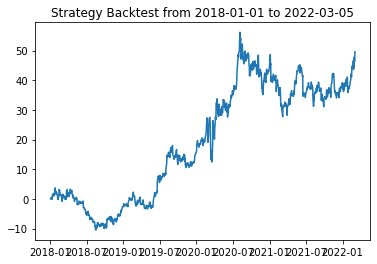

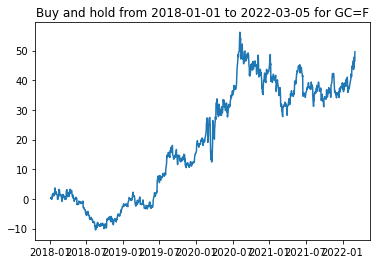

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03      0.190302           0.190302
 2018-01-04       0.24313           0.433895
 2018-01-05      0.068215           0.502405
 2018-01-08     -0.128764           0.372994
 ...                  ...                ...
 2022-02-28      0.683807          44.584007
 2022-03-01      2.263873          47.857205
 2022-03-02     -1.106878          46.220606
 2022-03-03      0.702796          47.248238
 2022-03-04      1.587053          49.585145
 
 [1051 rows x 2 columns],
 0.4154884089975461,
 0.5383114643026704]

In [5]:
testbh = StrategyBuyAndHold(["GC=F"])
testbh.evaluate("2018-01-01","2022-03-05",fig_other=True)

## Task 1 Time Series Momentum Strategy
The aim of this task is to implement a backtest for the time series momentum strategy:

- This strategy will take a postion in every asset in the given basket.
- If an asset has a negative historic return then a short positon is taken and if it has a postitve histioric return then it a long postion is taken.
- The lookback period for which returns are calculated is the previous t days. 
- We will also only adjust our portfolio weights every q days.
Note the first date that we can calculate weights will be on date (t+1) so we aim to adjust our portfolio weights every q days after this.
- We then aim to normalize our weights by ensuring the sum of the absolute values of all weights on any given date is 1.

In [6]:
class StrategyTimeSeriesMomentum(Strategies):
    """
    Implementation of a TS momentum strategy.
    params:
    ------
    start_date, end_date strings of dates
    t = lookback period length for calculating momentum of each stock
    q = time length between portfolio adjustements
    ------
    """
    def backtest(self, start_date, end_date, q=10, t=50):
    # imports all code from the parent class
      Strategies.backtest(self, start_date, end_date)
      # loop through each time step to calculate the signals
      # hint start at time t+1  and loop through all remaining time vals
      for i in range(t, len(self.data)):
        if not (i-t) % q:
          # for each time step define a variable signals that is a pd Series with 
          # index of stock codes, data equal to the percentage returns over the previous
          # t time steps.
          # select the p codes with a long position
          signals = pd.Series(data = (100*(self.data["Adj Close"][c][i-1]-self.data["Adj Close"][c][i-t])
                                    /self.data["Adj Close"][c][i-t] for c in self.codes),
                            index = self.codes)
        
          self.strat.iloc[i] = np.sign(signals)
        
          row_sum = sum((abs(self.strat[c][i]) for c in self.codes))
          if row_sum:
            self.strat.iloc[i] /= row_sum
        else:
          self.strat.iloc[i] = self.strat.iloc[i-1]
      return self.strat

[*********************100%***********************]  6 of 6 completed


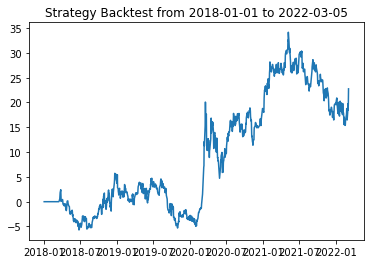

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      1.444062          18.152247
 2022-03-01      1.348912          19.746017
 2022-03-02     -1.096622          18.432856
 2022-03-03      1.116848          19.755571
 2022-03-04      2.503532           22.75369
 
 [1014 rows x 2 columns],
 0.236672626916093,
 0.3339034737086902]

In [7]:
testTSM = StrategyTimeSeriesMomentum(["^FTSE","GC=F","ZC=F","AMZN","SIE.DE","SIEGY"])
testTSM.evaluate("2018-01-01","2022-03-05", t=50)

## Task 2: Relative Momentum Strategy
The aim of this task is to implement a backtest for the relative momentum strategy:

- For each date the strategy will take a long postion in the p best previous performing stocks and a short postion in the p worst performing stocks. 
- The lookback period for which performance will be judged will be the previous t days. 
- We will also only adjust our portfolio weights every q days.
Note the first date that we can calculate weights will be on date (t+1) so we aim to adjust our portfolio weights every q days after this.

For the worst performing stocks the weights should be negative and for the best performing stocks weights postitive such that the sum of the absolute values across each row of the strategy weights is equal to 1!! I.e the weights for the worst stocks are -1/(2p) and for the best p stocks 1/(2p). All other weights are 0.

For this algorithm performance is measured by cumulative returns.

In [8]:
class StrategyRelativeMomentum(Strategies):
    """
    Implementation of a relative momentum strategy.
    params:
    ------
    start_date, end_date strings of dates
    p = half the number of stocks a postion a is taken in
    t = lookback period length for calculating momentum of each stock
    q = time length between portfolio adjustements
    ------
    """
    def backtest(self, start_date, end_date, p=2, q=14, t=50):
      # imports all code from the parent class
      Strategies.backtest(self, start_date, end_date)
      # loop through each time step to calculate the signals
      # hint start at t+1 and loop through all remaining vals
      for i in range(t, len(self.data)):
        if (i-(t)) % q == 0:
          # for each time step define a variable signals that is a pd Series with 
          # index of stock codes, data equal to the percentage returns over the previous
          # t time steps.
          # use the sort_values() command to sort into descending order
          signals = pd.Series(data = (100*(self.data["Adj Close"][c][i-1]-self.data["Adj Close"][c][i-t])
                                      /self.data["Adj Close"][c][i-t] for c in self.codes),
                              index = self.codes).sort_values()

          # select the p codes with a long position
          for c in signals[-p:].keys():
            self.strat[c][i] = 1/(2*p)
          # select the p codes with a short position
          for c in signals[:p].keys():
            self.strat[c][i] = -1/(2*p)

        else:
          self.strat.iloc[i] = self.strat.iloc[i-1]
      return self.strat


[*********************100%***********************]  6 of 6 completed


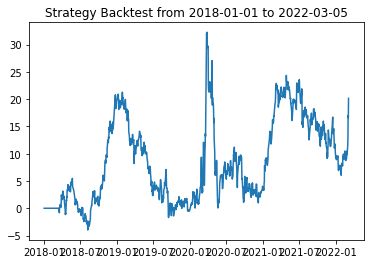

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      1.569238          11.560048
 2022-03-01      1.157458          12.851309
 2022-03-02       3.68213          17.006641
 2022-03-03     -0.357653          16.588163
 2022-03-04      3.054493          20.149341
 
 [1033 rows x 2 columns],
 0.17858038589486547,
 0.2472009075371158]

In [9]:
testRM = StrategyRelativeMomentum(["HG=F","GC=F","ZC=F", "SI=F", "PA=F","RB=F"])
testRM.evaluate("2018-01-01","2022-03-05", t=50)

## Task 4: RSI Momentum  Strategy with Weighting Extension
This task involves calculating the RSI for each stock and then using this value as a trading signal. From the Powerpoint Slides the formula for the RSI is given by:
 $$\text{RSI} = 1 - \frac{1}{\left(1+\text{abs}\left(\frac{\text{average of previous gains}}{\text{average of previous losses}}\right)\right)}$$

The value of the RSI ranges from 0 to 1.

The RSI is a useful oscillator that indicates the following few things:
If the value of the RSI is close to 0 then this indicates that the asset is underpriced and the asset should be bought. If the RSI is close to one then this indicates it is over priced and the asset should be sold. These low and high boundary values of the RSI are 0.3 and 0.7 respectively


This algorithm will do the following:
  - Calculate the RSI at each date.
  - If the RSI is less than 0.3 then enter a long position
  - If the RSI is greater than 0.3 then enter a short position
  - If the RSI is somewhere inbetween then keep the same postion as at the previous date
  - The lookback period for which previous average returns will be calculated is given by the parameter t
  - The Boolean parameter weighting will if True implement a type of user defined weighting strategies or if False will weight each stock equally.
  - Note that we want the weightings of the portfolio to only change when the RSI drops below 0.3 or rises above 0.7.

###Weighting Functions
The weighting function $\text{w(x)}$ in this case will simply be an algebraic function of the RSI value. It is important that this function  maps as follows $\text{w}\left([0,1]\right)\rightarrow [-1,1]$ with $\text{w}(0) > 0,\text{w}(1) < 0$.

Another ideal property of the weighting function in this case is that it is "heavy tailed". i.e for medium values it is very close to zero with more mass centered close to the endpoints. It also is intuitive that the weighting function must be decreasing.

Some common examples of these types of weighting functions include various polynomials including the following simple linear polynomial symmetric about $\frac{1}{2}$.
$$w(x) = k_1\left(\frac{1}{2}-x\right)$$

(note the constant $k_1$ above is not necassry to be calculated as when coding we will normalize all the weightings)

One problem with the above function however is that although it is heavy tailed it is symmetric and an investor may wish to use a weighting function that protects against the risks of short selling. So may want to consider the following weighting function:
$$w(x) = k_1\left(\frac{1}{2}+ϵ-x\right) \text{for } ϵ>0$$

This can be achieved by allowing for less mass close to -1.
This can of course still be achieved using polynomials but can also be done use non polynomial functions like $\frac{1}{x}, \ln$ and $\arctan$ etc. However it is often best to use polynomials and polynomial approximations for computational effeciency.

Note other weighting methods are also possible that do not involve weighting or smoothing functions but instead use historic data to produce a weighting method.
One such example is the method of inverse volatility weighting where i,e assets with a smaller previous standard deviations over a lookback period have a higher weighting.



In [10]:
class StrategyRSI(Strategies):

  def backtest(self, start_date, end_date, t=14, q=14, weighting = False):
    Strategies.backtest(self, start_date, end_date)
    RSI = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)

    for i in range(t, len(self.data)):

      data_pct_change = self.data["Adj Close"][i-t:i].pct_change()

      numerator = pd.Series(data = (data_pct_change[c][(data_pct_change[c] >= 0)].mean()
                                         for c in self.codes),
                            index = self.codes)
      
      denominator = pd.Series(data =  (data_pct_change[c][(data_pct_change[c] <= 0)].mean()
                                            for c in self.codes),
                              index = self.codes)
      for c in self.codes:
        if numerator.isnull()[c]:
          RSI[c][i] = 0
        elif denominator.isnull()[c]:
          RSI[c][i] = 1
        else:
          RSI[c][i] = 1 - 1/(1-numerator[c]/denominator[c])
      
        if not weighting:     
          if RSI[c][i] < 0.3:
            self.strat[c][i] = 1
          elif RSI[c][i] > 0.7:
            self.strat[c][i] = 0
          else:
            self.strat[c][i] = self.strat[c][i-1]

        else:
          if (i - t) % q:
            self.strat.iloc[i] = (0.8 - RSI.iloc[i])
          else:
            self.strat.iloc[i] = self.strat.iloc[i-1]

      row_sum = sum(abs(self.strat.iloc[i]))
      if row_sum:
          self.strat.iloc[i] /= row_sum
      else:
        self.strat.iloc[i] = self.strat.iloc[i-1]
        
    return self.strat

[*********************100%***********************]  8 of 8 completed


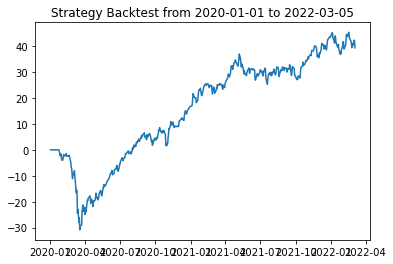

[           daily returns cumulative returns
 Date                                       
 2020-01-02             0                0.0
 2020-01-03           0.0                0.0
 2020-01-06           0.0                0.0
 2020-01-07           0.0                0.0
 2020-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28     -0.495956          40.417013
 2022-03-01      0.038829          40.471535
 2022-03-02      1.316922          42.321436
 2022-03-03     -0.201847          42.034165
 2022-03-04     -1.884986          39.356842
 
 [531 rows x 2 columns],
 0.2841553886112403,
 0.3215267047874569]

In [11]:
testRSI = StrategyRSI(["^FTSE","^GSPC","AAPL","GC=F","ZC=F","HG=F","SIEGY","SIE.DE"])
testRSI.evaluate("2020-01-01","2022-03-05", t=14, weighting= True)